In [4]:
# Install newer version of Pytorch
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl

# Cloning ONLY colab-integration branch
from getpass import getpass
import os

user = getpass('Github user')
password = getpass('Githyb password')
os.environ['GITHUB_AUTH'] = user + ':' + password
!git clone -b colab-integration --single-branch "https://$GITHUB_AUTH@github.com/baltekgajda/LegoSortingRecognition.git"

# Navigate to project folder
os.chdir("./LegoSortingRecognition")

# Create dir for models and results
!mkdir models


Github user··········
Githyb password··········
Cloning into 'LegoSortingRecognition'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 173 (delta 91), reused 118 (delta 47), pack-reused 0
Receiving objects: 100% (173/173), 53.70 KiB | 7.67 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [0]:
# Import necessary libraries
from __future__ import print_function
from __future__ import division
from google.colab import drive
import numpy as np
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import json

from data_loader import load_data
from feature_extraction import train_classifier_only, train_classifier_and_last_conv, train_full_net, train_simplified_net
from net_test_and_metrics import test_network
from svm_classification import train_model_with_svm
import VGGFactory

In [0]:
# Mount Google Drive to access data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def save_to_json(variable, results_folder, file_name):
  as_json = json.dumps(variable)
  f = open(RESULTS_FOLDER + file_name,"w")
  f.write(as_json)
  f.close()

In [0]:
def save_to_csv(variable, results_folder, file_name):
    np.savetxt(results_folder + file_name, variable, delimiter=',')

Initializing Datasets and Dataloaders...
Epoch 0/0
----------
train Loss: 2.9962 Acc: 0.0312
val Loss: 2.9958 Acc: 0.1111

Training complete in 0m 3s
Best val Acc: 0.111111
Epoch 0/0
----------
train Loss: 2.9976 Acc: 0.0000
val Loss: 2.9964 Acc: 0.0000

Training complete in 0m 2s
Best val Acc: 0.000000
Epoch 0/0
----------
train Loss: 2.9958 Acc: 0.0000
val Loss: 2.9944 Acc: 0.1111

Training complete in 0m 2s
Best val Acc: 0.111111
Epoch 0/0
----------
train Loss: 2.9967 Acc: 0.0312
val Loss: 2.9955 Acc: 0.1111

Training complete in 0m 2s
Best val Acc: 0.111111
SVM val Acc: 0.2222
SVM training complete in 0m 15s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM val Acc: 0.2222
SVM training complete in 0m 14s


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM val Acc: 0.2222
SVM training complete in 0m 14s


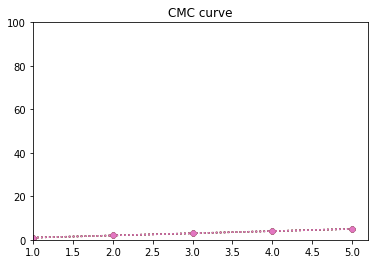

In [8]:
NUM_OF_CLASSES = 20
NUM_OF_EPOCHS = 50
INPUT_SIZE = 224
DATA_DIR = '/content/drive/My Drive/Studia/SNR/lego/'
MODELS_FOLDER = '/content/drive/My Drive/Studia/SNR/models/'
RESULTS_FOLDER = '/content/drive/My Drive/Studia/SNR/results/'

print("Initializing Datasets and Dataloaders...")
dataloaders_dict = load_data(DATA_DIR, INPUT_SIZE, batch_size=4, num_workers=4)


if (torch.cuda.is_available() == False):
  raise RuntimeError("GPU is not available!")   
device = torch.device("cuda:0")

torch.cuda.current_device()


model, hist_classifier, test_hist  = train_full_net(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
metrics = test_network(model, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
save_to_json(test_hist, RESULTS_FOLDER, "test_hist_on_full_net.json")
save_to_json(hist_classifier, RESULTS_FOLDER, "hist_on_full_net.json")
save_to_json(metrics, RESULTS_FOLDER, "metrics_on_full_net.json")

m_simplified, hist_classifier, test_hist  = train_simplified_net(model, dataloaders_dict, MODELS_FOLDER, device, num_of_epochs=NUM_OF_EPOCHS)
metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
save_to_json(test_hist, RESULTS_FOLDER, "test_hist_simplified.json")
save_to_json(hist_classifier, RESULTS_FOLDER, "hist_simplified.json")
save_to_json(metrics, RESULTS_FOLDER, "metrics_simplified.json")

model, hist_classifier, test_hist = train_classifier_only(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
metrics = test_network(model, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
save_to_json(test_hist, RESULTS_FOLDER, "test_hist_classifier.json")
save_to_json(hist_classifier, RESULTS_FOLDER, "hist_classifier.json")
save_to_json(metrics, RESULTS_FOLDER, "metrics_classifier.json")

model, hist_classifier, test_hist  = train_classifier_and_last_conv(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
metrics = test_network(model, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc')
save_to_json(test_hist, RESULTS_FOLDER, "test_hist_hist_last_conv.json")
save_to_json(hist_classifier, RESULTS_FOLDER, "hist_last_conv.json")
save_to_json(metrics, RESULTS_FOLDER, "metrics_last_conv.json")

svm_model = train_model_with_svm(m_simplified, dataloaders_dict, kernel='l')
metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc', svm_classifier=svm_model)
save_to_json(metrics, RESULTS_FOLDER, "metrics_linear_svm.json")

svm_model = train_model_with_svm(m_simplified, dataloaders_dict, kernel='q')
metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc', svm_classifier=svm_model)
save_to_json(metrics, RESULTS_FOLDER, "metrics_quadratic_svm.json")

svm_model  = train_model_with_svm(m_simplified, dataloaders_dict, kernel='e')
metrics = test_network(m_simplified, dataloaders_dict['test'], NUM_OF_CLASSES, device, plot_name='cmc', svm_classifier=svm_model)
save_to_json(metrics, RESULTS_FOLDER, "metrics_exponential_svm.json")

# m_classifier, hist_classifier = train_classifier_only(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
# metrics_classifier = test_network(m_classifier, dataloaders_dict['test'], device, plot_name='cmc')
# save_to_json(hist_classifier, RESULTS_FOLDER, "hist_classifier.json")
# save_to_json(metrics_classifier, RESULTS_FOLDER, "metrics_classifier.json")

# m_last_conv, hist_last_conv = train_classifier_and_last_conv(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
# metrics_last_conv = test_network(m_last_conv, dataloaders_dict['test'], device, plot_name='cmc')
# save_to_json(hist_last_conv, RESULTS_FOLDER, "hist_last_conv.json")
# save_to_json(metrics_last_conv, RESULTS_FOLDER, "metrics_last_conv.json")

# m_on_full_net, hist_on_full_net = train_full_net(dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
# metrics_on_full_net = test_network(m_on_full_net, dataloaders_dict['test'], device, plot_name='cmc')
# save_to_json(hist_on_full_net, RESULTS_FOLDER, "hist_on_full_net.json")
# save_to_json(metrics_on_full_net, RESULTS_FOLDER, "metrics_on_full_net.json")

# m_simplified, hist_simplified = train_simplified_net(model_on_full_net, dataloaders_dict, MODELS_FOLDER, device, num_of_classes=NUM_OF_CLASSES, num_of_epochs=NUM_OF_EPOCHS)
# metrics_simplified_net = test_network(m_simplified, dataloaders_dict['test'], device, plot_name='cmc')
# save_to_json(hist_simplified, RESULTS_FOLDER, "hist_simplified.json")
# save_to_json(metrics_on_full_net, RESULTS_FOLDER, "metrics_on_full_net.json")

In [0]:
import os
import shutil

os.chdir("/content")
shutil.rmtree('./LegoSortingRecognition')

In [0]:
# num_classes = 20
# num_of_epochs = 50
# input_size = 224

# model = VGGFactory.create_model(1, num_classes)
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

# print()

# simple_model = VGGFactory.simplify_model(model)
# for name, param in simple_model.named_parameters():
#     if param.requires_grad:
#         print(name)

# print("Initializing Datasets and Dataloaders...")
# dataloaders_dict = load_data(data_dir, input_size, 0.3, 0.1, 0.1)

# params_to_update = model.parameters()
# print("Params to learn:")
# params_to_update = []
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         params_to_update.append(param)
#         print("\t", name)

# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# # Setup the loss fxn
# criterion = nn.CrossEntropyLoss()

# # Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Necessary to run script on Windows
# torch.cuda.current_device()

# # Train and evaluate
# model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, device, num_epochs=num_of_epochs)

# # Save trained model
# utils.save_model(model_ft, "./models")
